# Train a `biolord` model over the spatiotemporally resolved single cell atlas of the Plasmodium for abortive state analysis

This notebook relies on pre-processed data obatained in `1_spatio-temporal-infection_preprocessing.ipynb`<br>
Alternatively the processed adata can be downloaded from figshare, [`adata_abortive.h5ad`](https://figshare.com/ndownloader/files/39375752).

Here we train a `biolord` model on the spatio-temporally resolved single cell atlas of the Plasmodium liver stage[[1]](https://www.nature.com/articles/s41586-022-05406-5) to extend the classification of `Abortive state` (provided for 36 hpi) to earlier stages of infection (24 and 30 hpi).

[[1] Afriat, Amichay, Vanessa Zuzarte-Luís, Keren Bahar Halpern, Lisa Buchauer, Sofia Marques, Ângelo Ferreira Chora, Aparajita Lahree, Ido Amit, Maria M. Mota, and Shalev Itzkovitz. "A spatiotemporally resolved single-cell atlas of the Plasmodium liver stage." Nature 611, no. 7936 (2022): 563-569.](https://www.nature.com/articles/s41586-022-05406-5)



## load packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import scanpy as sc
import anndata
import numpy as np
import pandas as pd
import torch
import re
import itertools

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import biolord

from scipy.stats import mannwhitneyu, normaltest, wilcoxon
from statsmodels.stats.multitest import fdrcorrection
from statannotations.Annotator import Annotator

import warnings

[rank: 0] Global seed set to 0


In [3]:
sys.path.append("../../")
sys.path.append("../../utils/")
from paths import DATA_DIR, FIG_DIR

warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FutureWarning)

## Set parameters

In [4]:
import mplscience

mplscience.set_style()
plt.rcParams["legend.scatterpoints"] = 1

In [5]:
DATA_DIR_LCL = str(DATA_DIR) + "/spatio-temporal-infection/"
FIG_DIR_LCL = str(FIG_DIR) + "/spatio-temporal-infection/"

In [6]:
abortive_genes = [
    "Myc",
    "Mdm2",
    "Cdkn1a",
    "Sqstm1",
    "Cxcl10",
    "Nfkbia",
    "Hes1",
    "Ifnb1",
]

## Import pre-processed data

In [7]:
adata = sc.read(
    DATA_DIR_LCL + "adata_abortive.h5ad",
    backup_url="https://figshare.com/ndownloader/files/39375752",
)

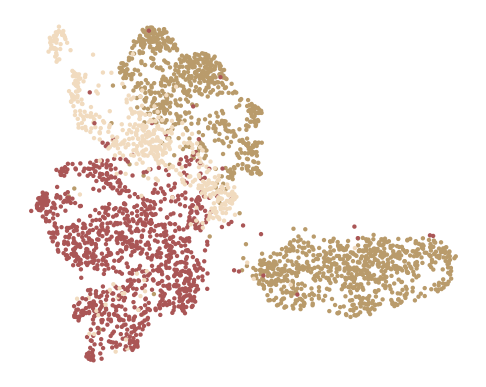

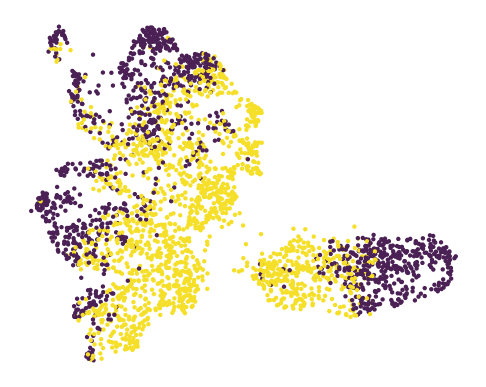

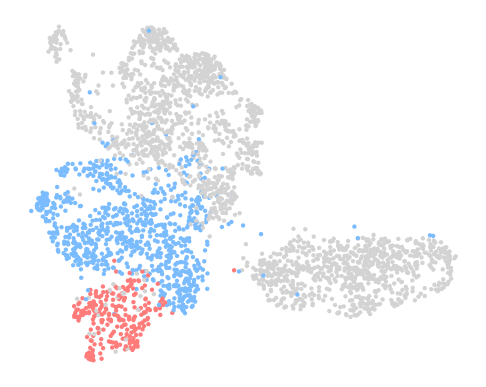

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


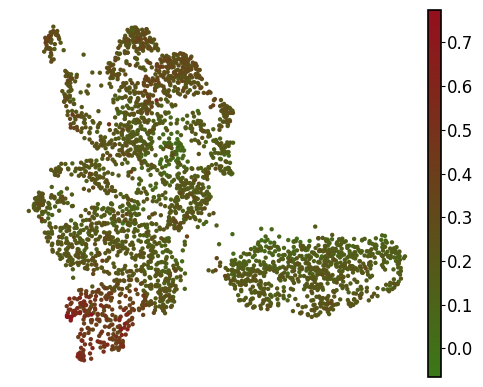

In [8]:
for c in ["coarse_time", "zone", "abortive_state", "stress_score"]:
    fig, axs = plt.subplots(1, 1, figsize=(5, 4))

    sc.pl.umap(
        adata,
        color=[c],
        ax=axs,
        show=False,
        cmap=sns.color_palette("blend:#3a7818,#940f1c", as_cmap=True),
    )

    axs.set_title("")
    axs.set_axis_off()
    plt.legend().remove()
    plt.tight_layout()
    plt.savefig(
        FIG_DIR_LCL + f"late_cells_{c}_nleg.png",
        dpi=300,
        bbox_inches="tight",
        transparent=True,
    )
    plt.show()

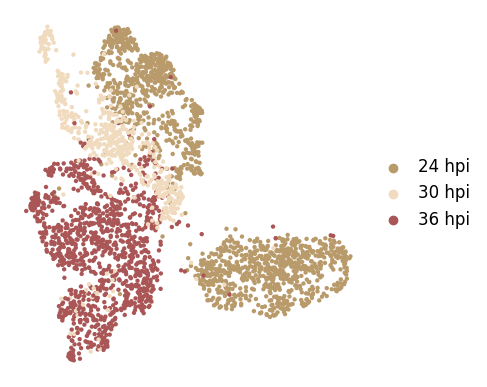

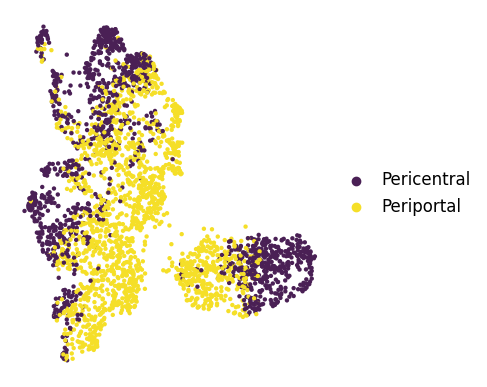

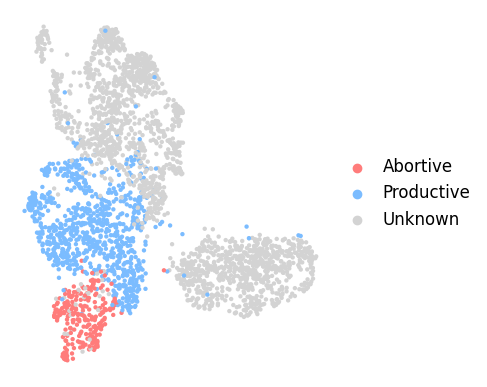

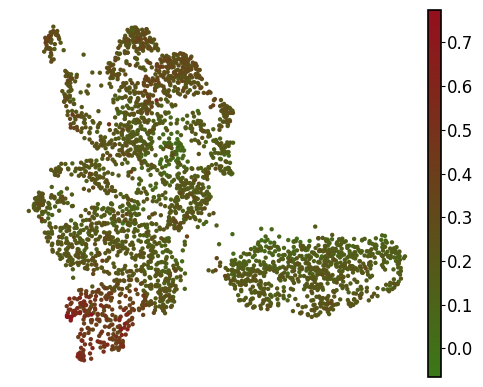

In [9]:
for c in ["coarse_time", "zone", "abortive_state", "stress_score"]:
    fig, axs = plt.subplots(1, 1, figsize=(5, 4))

    sc.pl.umap(
        adata,
        color=[c],
        ax=axs,
        show=False,
        cmap=sns.color_palette("blend:#3a7818,#940f1c", as_cmap=True),
    )

    axs.set_title("")
    axs.set_axis_off()
    plt.tight_layout()
    plt.savefig(
        FIG_DIR_LCL + f"late_cells_{c}.png",
        dpi=300,
        bbox_inches="tight",
        transparent=True,
    )
    plt.show()

In [10]:
biolord.Biolord.setup_anndata(
    adata,
    ordered_attributes_keys=["stress_score"],
    categorical_attributes_keys=["time_int", "abortive_state", "zone"],
    categorical_attributes_missing={
        "time_int": None,
        "abortive_state": "Unknown",
        "zone": None,
    },
    retrieval_attribute_key=None,
)

### Train model

In [11]:
module_params = {
    "autoencoder_width": 512,
    "autoencoder_depth": 4,
    "attribute_nn_width": 512,
    "attribute_nn_depth": 4,
    "use_batch_norm": False,
    "use_layer_norm": False,
    "unknown_attribute_noise_param": 1e-1,
    "seed": 42,
    "n_latent_attribute_ordered": 16,
    "n_latent_attribute_categorical": 4,
    "gene_likelihood": "normal",
    "classification_penalty": 0,
    "classifier_penalty": 1e1,
    "reconstruction_penalty": 1e1,
    "unknown_attribute_penalty": 1e2,
    "attribute_dropout_rate": 0.05,
    "eval_r2_ordered": False,
    "classifier_dropout_rate": 0.05,
    "classify_all": False,
}

In [12]:
model = biolord.Biolord(
    adata=adata,
    n_latent=32,
    model_name="spatiotemporal_malaria_abortive",
    train_classifiers=True,
    module_params=module_params,
    split_key="split_random",
)

[rank: 0] Global seed set to 42


In [13]:
trainer_params = {
    "n_epochs_warmup": 0,
    "autoencoder_lr": 1e-4,
    "autoencoder_wd": 1e-4,
    "attribute_nn_lr": 1e-2,
    "attribute_nn_wd": 4e-8,
    "step_size_lr": 90,
    "cosine_scheduler": True,
    "scheduler_final_lr": 1e-5,
}

In [14]:
model.train(
    max_epochs=200,
    batch_size=256,
    plan_kwargs=trainer_params,
    early_stopping=True,
    early_stopping_patience=20,
    check_val_every_n_epoch=10,
    num_workers=1,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 90/200:  45%|████▌     | 90/200 [01:56<02:21,  1.29s/it, v_num=1, val_generative_mean_accuracy=0.963, val_generative_var_accuracy=0.802, val_biolord_metric=0.916, val_reconstruction_loss=0.728, val_unknown_attribute_penalty_loss=26.5, val_classification_accuracy=0.982, val_regression_r2_accuracy=0, val_regression_mse=0, val_classification_loss=0.395, generative_mean_accuracy=0, generative_var_accuracy=0, biolord_metric=0, reconstruction_loss=0.631, unknown_attribute_penalty_loss=31.4, classification_accuracy=0, regression_r2_accuracy=0, regression_mse=0, classification_loss=0.326]
Monitored metric val_biolord_metric did not improve in the last 20 records. Best score: 0.925. Signaling Trainer to stop.


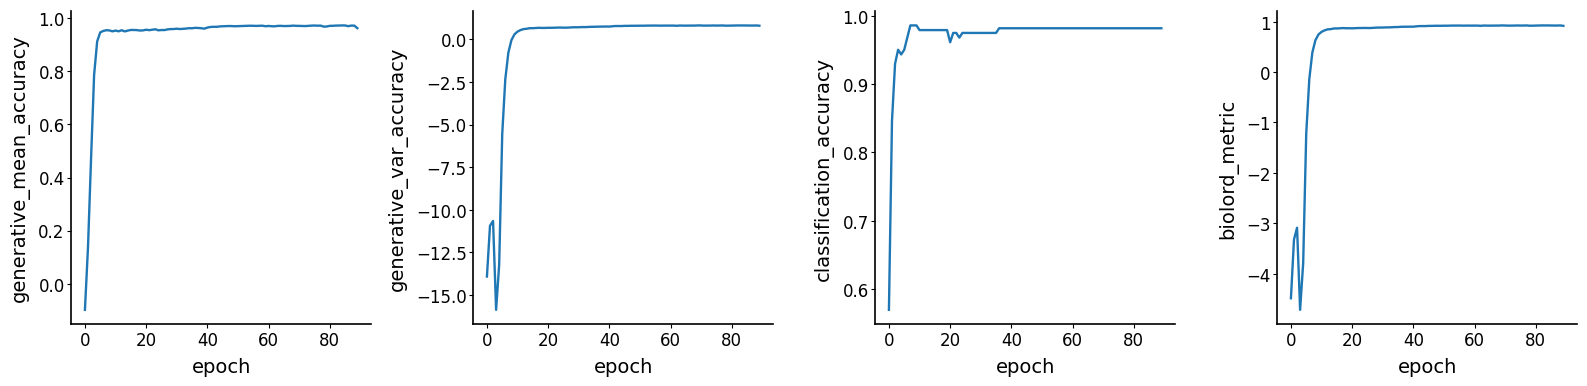

In [15]:
vals = [
    "generative_mean_accuracy",
    "generative_var_accuracy",
    "classification_accuracy",
    "biolord_metric",
]
fig, axs = plt.subplots(nrows=1, ncols=len(vals), figsize=(4 * len(vals), 4))

model.epoch_history = pd.DataFrame().from_dict(model.training_plan.epoch_history)
for i, val in enumerate(vals):
    sns.lineplot(
        x="epoch",
        y=val,
        data=model.epoch_history[model.epoch_history["mode"] == "valid"],
        ax=axs[i],
    )

plt.tight_layout()
plt.show()

## Get classification

In [16]:
idx_predict = np.where((adata.obs["coarse_time"] != "36 hpi"))[0]

adata_predict = adata[idx_predict].copy()

In [17]:
labels_color = {
    "coarse_time": "coarse time",
    "zone": "zone",
    "abortive_state_classification": "abortive (classification)",
    "abortive_state": "abortive (label)",
}

abortive_color = {
    "Abortive": "#ff7c7b",
    "Productive": "#7bbcff",
    "Unknown": "#BDBABB",
}

coarse_time_colors = {"24 hpi": "#B99B6B", "30 hpi": "#F1DBBF", "36 hpi": "#AA5656"}

In [18]:
dataset = model.get_dataset(adata)
classification = model.module.classify(dataset["X"])

for attribute_, vals_ in classification.items():
    if attribute_ in model.categorical_attributes_map:
        inv_map = {
            v: k for k, v in model.categorical_attributes_map[attribute_].items()
        }
        adata.obs[f"{attribute_}_classification"] = [
            inv_map[k] for k in vals_.argmax(dim=-1).cpu().numpy()
        ]
    else:
        adata.obs[f"{attribute_}_classification"] = vals_[0].detach().cpu().numpy()

adata.obs["abortive_state_classification"] = adata.obs[
    "abortive_state_classification"
].astype("category")

adata.uns["coarse_time_colors"] = [
    coarse_time_colors[cat] for cat in adata.obs["coarse_time"].cat.categories
]
adata.uns["abortive_state_colors"] = [
    abortive_color[cat] for cat in adata.obs["abortive_state"].cat.categories
]
adata.uns["abortive_state_classification_colors"] = [
    abortive_color[cat]
    for cat in adata.obs["abortive_state_classification"].cat.categories
]

for attribute_, vals_ in classification.items():
    adata.obs[f"{attribute_}_classification"] = adata.obs[
        f"{attribute_}_classification"
    ].astype("category")
    adata.obs[f"{attribute_}_classification_str"] = adata.obs[
        f"{attribute_}_classification"
    ].copy()
    adata.obs[f"{attribute_}_classification"] = adata.obs[
        f"{attribute_}_classification"
    ].cat.rename_categories(lambda x: str(x) + " (biolord-classify)")

adata.uns["zone_colors"] = ["#4A2055", "#F5DF28"]

sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

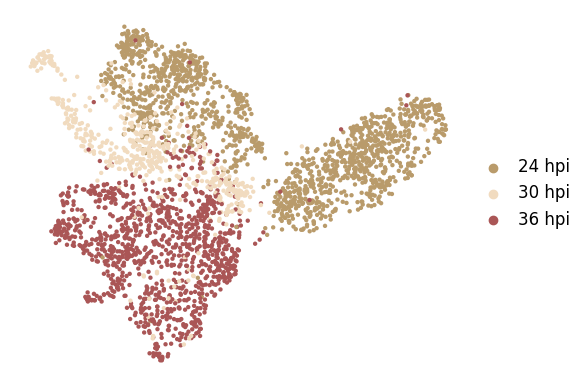

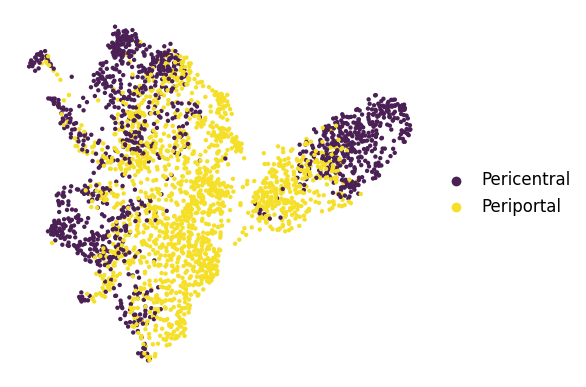

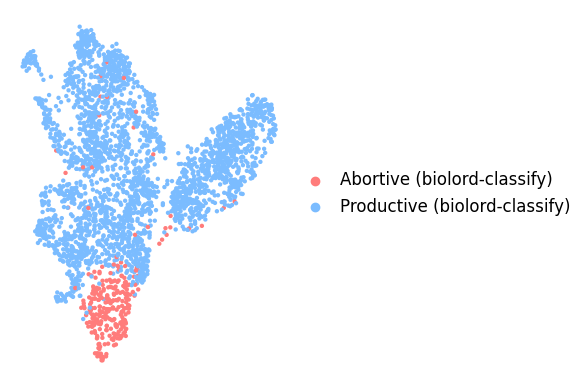

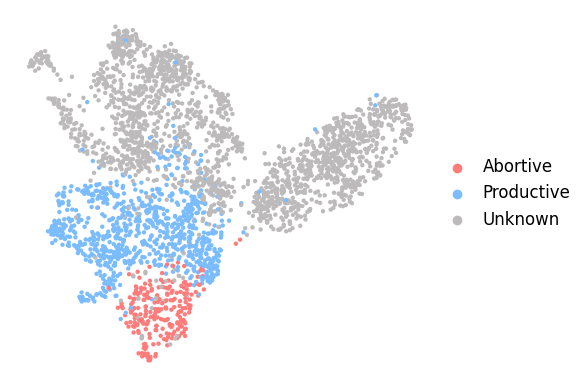

In [19]:
for c in ["coarse_time", "zone", "abortive_state_classification", "abortive_state"]:
    fig, axs = plt.subplots(1, 1, figsize=(6, 4))
    sc.pl.umap(
        adata,
        color=[c],
        ax=axs,
        show=False,
    )

    axs.set_title("")
    axs.set_axis_off()
    plt.tight_layout()
    plt.savefig(
        FIG_DIR_LCL + f"infected_cells_{c}.png",
        dpi=300,
        bbox_inches="tight",
        transparent=True,
    )
    plt.show()

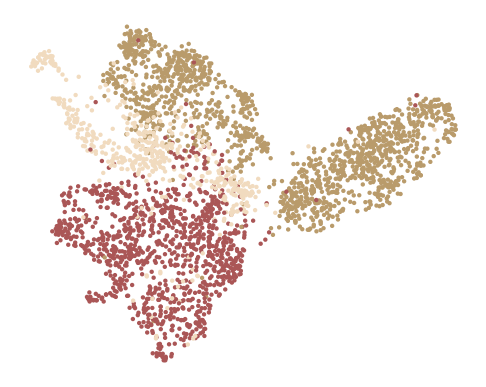

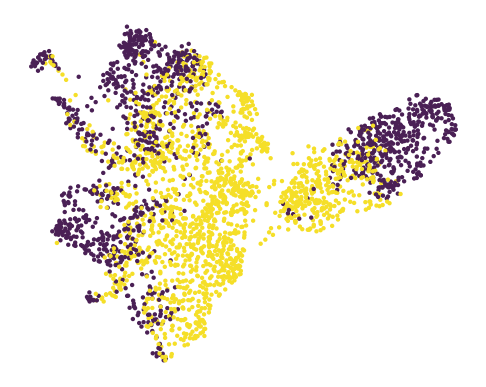

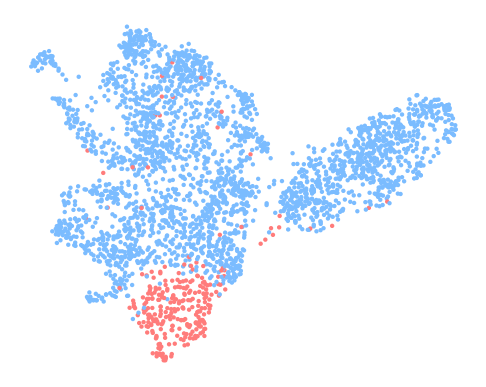

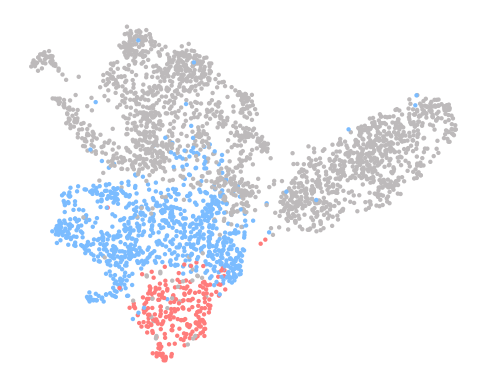

In [20]:
for c in ["coarse_time", "zone", "abortive_state_classification", "abortive_state"]:
    fig, axs = plt.subplots(1, 1, figsize=(5, 4))

    sc.pl.umap(
        adata,
        color=[c],
        ax=axs,
        show=False,
    )

    axs.set_title("")
    axs.set_axis_off()
    plt.legend().remove()
    plt.tight_layout()
    plt.savefig(
        FIG_DIR_LCL + f"infected_cells_{c}_nleg.png",
        dpi=300,
        bbox_inches="tight",
        transparent=True,
    )
    plt.show()

In [21]:
adata.obs[["abortive_state_classification_str", "abortive_state", "abortive"]].to_csv(
    DATA_DIR_LCL + "biolord_abortive_classifications.csv"
)

## Evaluate

In [22]:
## classification accuracy
acc = (
    adata[adata.obs["abortive_state"].isin(["Abortive", "Productive"])].obs[
        "abortive_state"
    ]
    == adata[adata.obs["abortive_state"].isin(["Abortive", "Productive"])].obs[
        "abortive_state_classification_str"
    ]
).sum() / adata.obs["abortive_state"].isin(["Abortive", "Productive"]).sum()
print(f"abortive state classification accuracy is: {acc:.2f}")

abortive state classification accuracy is: 1.00


In [23]:
hpis = {}
for hpi in adata.obs["coarse_time"].cat.categories:
    print(f"in {hpi}:")
    print(
        adata[adata.obs["coarse_time"].isin([hpi])]
        .obs["abortive_state_classification"]
        .value_counts()
        / adata[adata.obs["coarse_time"].isin([hpi])].shape[0]
    )
    hpis[hpi] = (
        adata[adata.obs["coarse_time"].isin([hpi])]
        .obs["abortive_state_classification"]
        .value_counts()
        / adata[adata.obs["coarse_time"].isin([hpi])].shape[0]
    ).to_dict()

in 24 hpi:
Productive (biolord-classify)    0.98416
Abortive (biolord-classify)      0.01584
Name: abortive_state_classification, dtype: float64
in 30 hpi:
Productive (biolord-classify)    0.94274
Abortive (biolord-classify)      0.05726
Name: abortive_state_classification, dtype: float64
in 36 hpi:
Productive (biolord-classify)    0.784857
Abortive (biolord-classify)      0.215143
Name: abortive_state_classification, dtype: float64


In [24]:
df_hpis = pd.DataFrame(hpis).T.reset_index()
df_hpis["Productive (biolord-classify)"] = 0.25
df_hpis

,index,Productive (biolord-classify),Abortive (biolord-classify)
0,24 hpi,0.25,0.015840
1,30 hpi,0.25,0.057260
2,36 hpi,0.25,0.215143


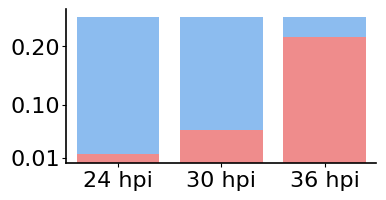

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(4, 2))

# from raw value to percentage

# bar chart 1 -> top bars (group of 'smoker=No')
bar1 = sns.barplot(
    x="index",
    y="Productive (biolord-classify)",
    data=df_hpis,
    color=abortive_color["Productive"],
)

# bar chart 2 -> bottom bars (group of 'smoker=Yes')
bar1 = sns.barplot(
    x="index",
    y="Abortive (biolord-classify)",
    data=df_hpis,
    color=abortive_color["Abortive"],
)

# # add legend
# top_bar = mpatches.Patch(color=abortive_color["Productive"], label='Productive')
# bottom_bar = mpatches.Patch(color=abortive_color["Abortive"], label='Abortive')
# plt.legend(handles=[top_bar, bottom_bar])

plt.yticks(
    [
        0.01,
        0.1,
        0.2,
    ],
    fontsize=16,
)
plt.xticks([0, 1, 2], ["24 hpi", "30 hpi", "36 hpi"], fontsize=16, rotation=0)
# show the graph
plt.xlabel("")
plt.ylabel("")
plt.savefig(
    FIG_DIR_LCL + "abortive_frac.png", format="png", dpi=300, bbox_inches="tight"
)
plt.show()

### Spatial and parasite mRNA distribution

In [26]:
adata.obs["label_type"] = "biolord-classify"
adata.obs.loc[adata.obs["coarse_time"] == "36 hpi", "label_type"] = "original"

In [27]:
df = adata.obs[
    [
        "label_type",
        "abortive_state_classification",
        "normalized_PBA",
        "eta_normalized",
        "zone",
        "coarse_time",
        "pseudotime",
    ]
]

In [28]:
plotting_parameters = {
    "data": df,
    "x": "label_type",
    "y": "normalized_PBA",
    "hue": "abortive_state_classification",
    "palette": adata.uns["abortive_state_classification_colors"],
}

pairs = [
    [
        ("biolord-classify", "Abortive (biolord-classify)"),
        ("biolord-classify", "Productive (biolord-classify)"),
    ],
    [
        ("original", "Abortive (biolord-classify)"),
        ("original", "Productive (biolord-classify)"),
    ],
]

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

original_Abortive (biolord-classify) vs. original_Productive (biolord-classify): Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.170e-53 U_stat=3.396e+04
biolord-classify_Abortive (biolord-classify) vs. biolord-classify_Productive (biolord-classify): Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:8.192e-11 U_stat=2.253e+04


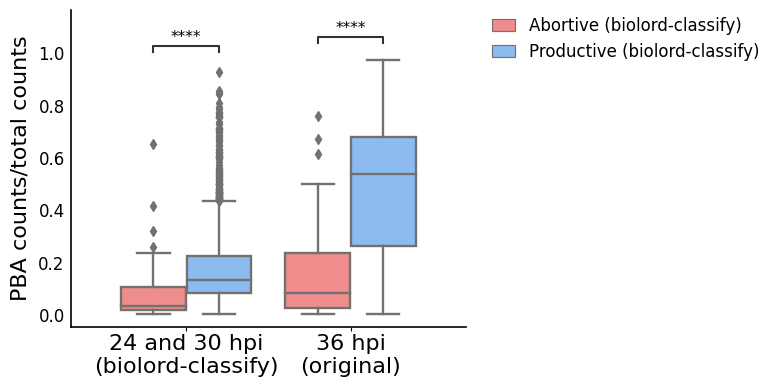

In [29]:
size = 4
fig, ax = plt.subplots(1, 1, figsize=(size * 2, size))

sns.boxplot(**plotting_parameters)

# Add annotations
annotator = Annotator(ax, pairs, **plotting_parameters)
annotator.configure(
    test="Mann-Whitney", comparisons_correction="Benjamini-Hochberg"
).apply_and_annotate()

ax.set_xlabel("")
ax.set_ylabel("PBA counts/total counts", fontsize=16)
ax.set_xticklabels(
    ["24 and 30 hpi\n(biolord-classify)", "36 hpi\n(original)"], fontsize=16
)
ax.yaxis.set_ticks_position("none")

plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0)
plt.tight_layout()

plt.savefig(FIG_DIR_LCL + "PBA_counts_abortive_box.png", format="png", dpi=300)
plt.show()

In [30]:
plotting_parameters = {
    "data": df,
    "x": "label_type",
    "y": "eta_normalized",
    "hue": "abortive_state_classification",
    "palette": adata.uns["abortive_state_classification_colors"],
}


pairs = [
    [
        ("biolord-classify", "Abortive (biolord-classify)"),
        ("biolord-classify", "Productive (biolord-classify)"),
    ],
    [
        ("original", "Abortive (biolord-classify)"),
        ("original", "Productive (biolord-classify)"),
    ],
]

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

original_Abortive (biolord-classify) vs. original_Productive (biolord-classify): Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:3.056e-04 U_stat=1.143e+05
biolord-classify_Abortive (biolord-classify) vs. biolord-classify_Productive (biolord-classify): Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:6.546e-05 U_stat=6.396e+04


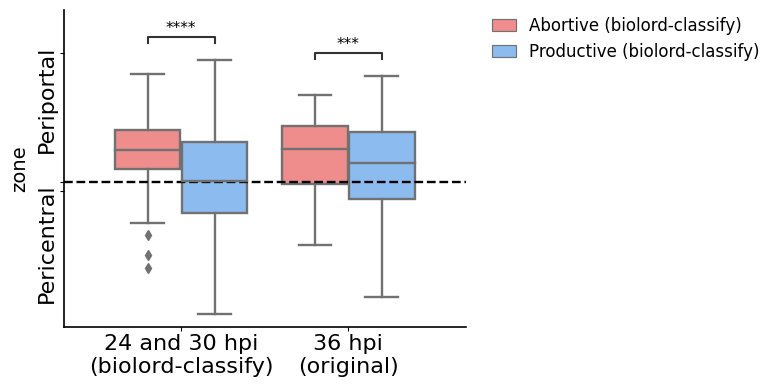

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

sns.boxplot(**plotting_parameters)  # "cut": 0; equivalent to ggplot trim=True

# Add annotations
annotator = Annotator(ax, pairs, **plotting_parameters)
annotator.configure(
    test="Mann-Whitney", comparisons_correction="Benjamini-Hochberg"
).apply_and_annotate()

th = adata[adata.obs["zone"] == "Pericentral"].obs["eta_normalized"].max()
ax.axhline(th, linestyle="--", color="black")
ax.set_xlabel("")
ax.set_ylabel("zone")
ax.set_yticks([0.48, th, 0.98])
ax.set_yticklabels(["Pericentral", "", "Periportal"], rotation=90, fontsize=16)
ax.set_xticklabels(
    ["24 and 30 hpi\n(biolord-classify)", "36 hpi\n(original)"], fontsize=16
)
# ax.yaxis.set_ticks_position("none")

plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0)
plt.tight_layout()

plt.savefig(FIG_DIR_LCL + "zonation_score_abortive_box.png", format="png", dpi=300)
plt.show()

In [32]:
plotting_parameters = {
    "data": df,
    "x": "label_type",
    "y": "pseudotime",
    "hue": "abortive_state_classification",
    "palette": adata.uns["abortive_state_classification_colors"],
}


pairs = [
    [
        ("biolord-classify", "Abortive (biolord-classify)"),
        ("biolord-classify", "Productive (biolord-classify)"),
    ],
    [
        ("original", "Abortive (biolord-classify)"),
        ("original", "Productive (biolord-classify)"),
    ],
]

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

original_Abortive (biolord-classify) vs. original_Productive (biolord-classify): Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.715e-35 U_stat=4.659e+04
biolord-classify_Abortive (biolord-classify) vs. biolord-classify_Productive (biolord-classify): Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.165e-07 U_stat=2.727e+04


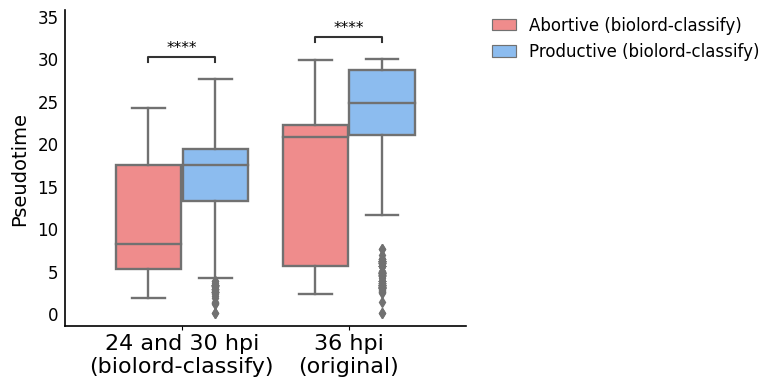

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

sns.boxplot(**plotting_parameters)

# Add annotations
annotator = Annotator(ax, pairs, **plotting_parameters)
annotator.configure(
    test="Mann-Whitney", comparisons_correction="Benjamini-Hochberg"
).apply_and_annotate()

# ax.axhline(0.39, linestyle="--",color="black")
ax.set_xlabel("")
ax.set_ylabel("Pseudotime")
ax.set_xticklabels(
    ["24 and 30 hpi\n(biolord-classify)", "36 hpi\n(original)"], fontsize=16
)
ax.yaxis.set_ticks_position("none")

plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0)
plt.tight_layout()

plt.savefig(FIG_DIR_LCL + "pseudotime_abortive_box.png", format="png", dpi=300)
plt.show()

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

original_Abortive (biolord-classify) vs. original_Productive (biolord-classify): Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.265e-41 U_stat=1.420e+05
biolord-classify_Abortive (biolord-classify) vs. biolord-classify_Productive (biolord-classify): Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:4.935e-07 U_stat=6.182e+04


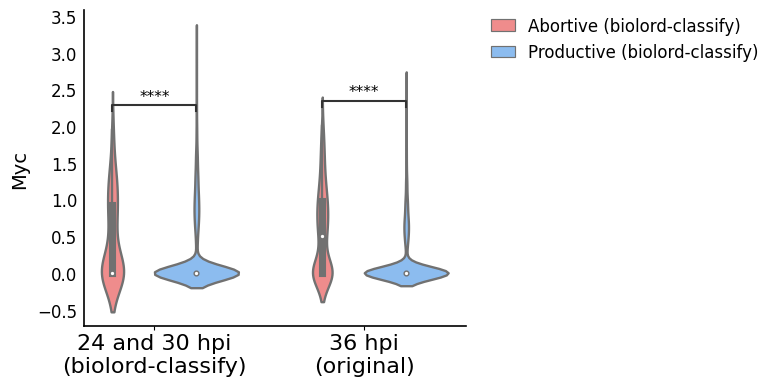

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

original_Abortive (biolord-classify) vs. original_Productive (biolord-classify): Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:8.544e-47 U_stat=1.505e+05
biolord-classify_Abortive (biolord-classify) vs. biolord-classify_Productive (biolord-classify): Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.786e-12 U_stat=6.503e+04


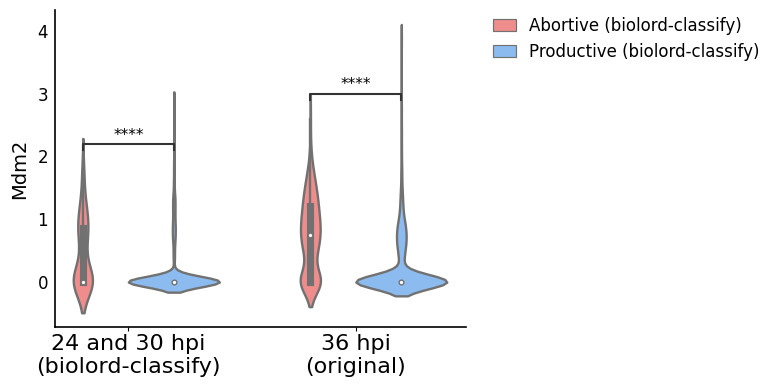

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

original_Abortive (biolord-classify) vs. original_Productive (biolord-classify): Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:3.036e-17 U_stat=1.311e+05
biolord-classify_Abortive (biolord-classify) vs. biolord-classify_Productive (biolord-classify): Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.207e-26 U_stat=6.775e+04


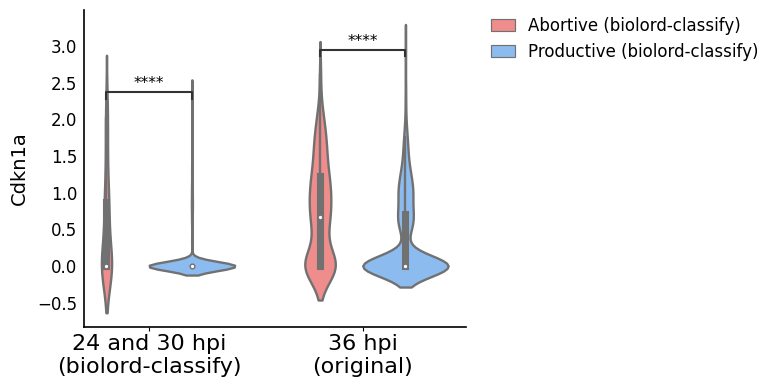

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

original_Abortive (biolord-classify) vs. original_Productive (biolord-classify): Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.270e-63 U_stat=1.702e+05
biolord-classify_Abortive (biolord-classify) vs. biolord-classify_Productive (biolord-classify): Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.035e-14 U_stat=7.864e+04


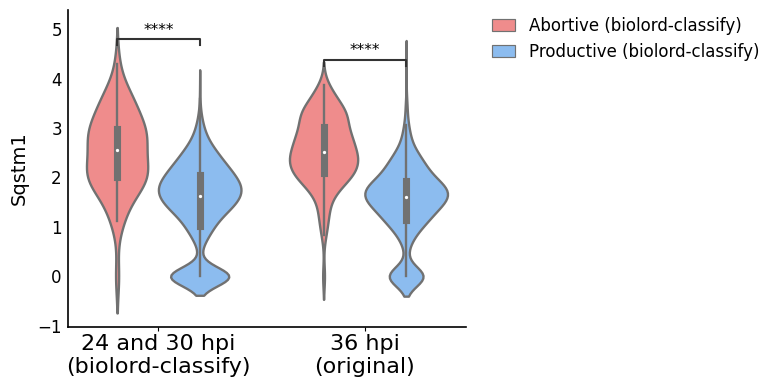

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

original_Abortive (biolord-classify) vs. original_Productive (biolord-classify): Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.557e-117 U_stat=1.811e+05
biolord-classify_Abortive (biolord-classify) vs. biolord-classify_Productive (biolord-classify): Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:7.201e-36 U_stat=7.543e+04


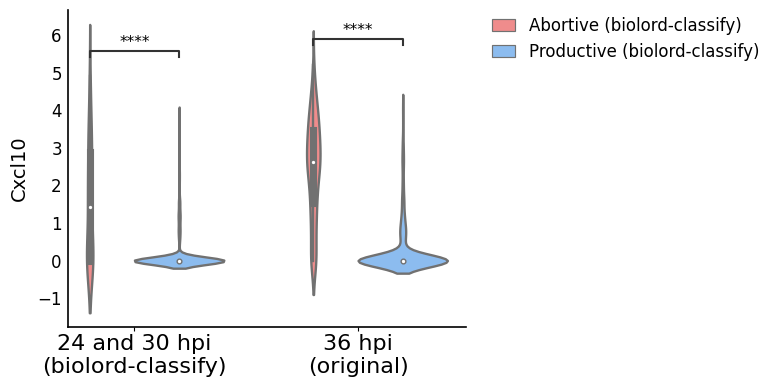

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

original_Abortive (biolord-classify) vs. original_Productive (biolord-classify): Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:4.665e-68 U_stat=1.666e+05
biolord-classify_Abortive (biolord-classify) vs. biolord-classify_Productive (biolord-classify): Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:8.786e-12 U_stat=6.974e+04


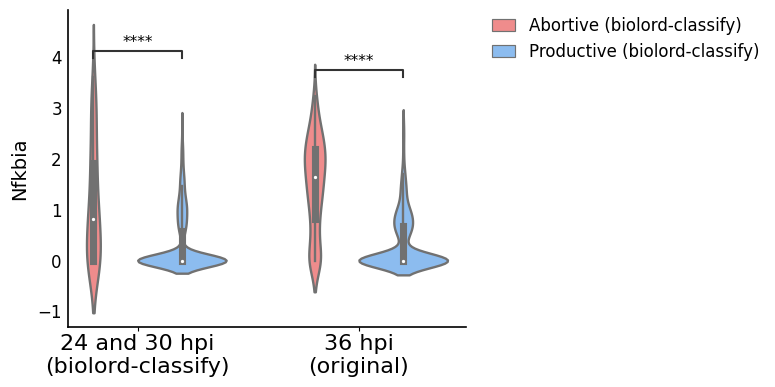

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

original_Abortive (biolord-classify) vs. original_Productive (biolord-classify): Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:5.211e-42 U_stat=1.299e+05
biolord-classify_Abortive (biolord-classify) vs. biolord-classify_Productive (biolord-classify): Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:3.185e-02 U_stat=5.106e+04


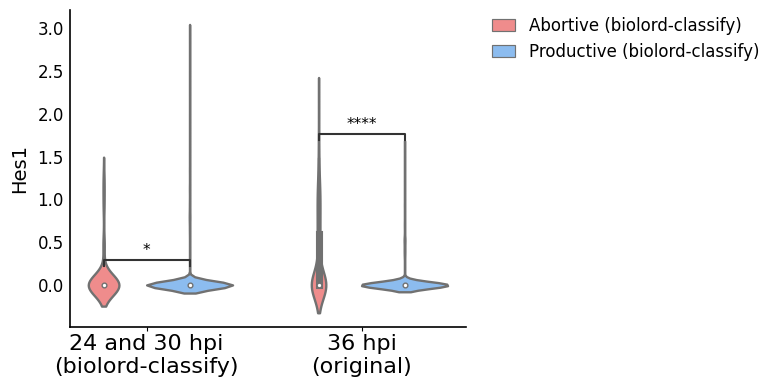

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

original_Abortive (biolord-classify) vs. original_Productive (biolord-classify): Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.985e-61 U_stat=1.377e+05
biolord-classify_Abortive (biolord-classify) vs. biolord-classify_Productive (biolord-classify): Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:3.246e-51 U_stat=5.751e+04


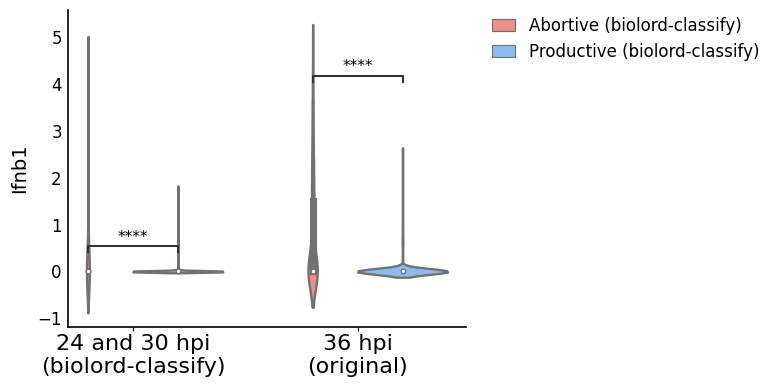

In [34]:
for gi, gene in enumerate(abortive_genes):
    df = adata.obs[["abortive_state_classification", "label_type"]].reset_index()
    df.loc[:, gene] = adata.X[:, adata.var_names.isin([gene])]

    plotting_parameters = {
        "data": df,
        "x": "label_type",
        "y": gene,
        "hue": "abortive_state_classification",
        "palette": adata.uns["abortive_state_classification_colors"],
    }

    pairs = [
        [
            ("biolord-classify", "Abortive (biolord-classify)"),
            ("biolord-classify", "Productive (biolord-classify)"),
        ],
        [
            ("original", "Abortive (biolord-classify)"),
            ("original", "Productive (biolord-classify)"),
        ],
    ]

    fig, ax = plt.subplots(1, 1, figsize=(8, 4))

    sns.violinplot(**plotting_parameters)

    # Add annotations
    annotator = Annotator(ax, pairs, **plotting_parameters)
    annotator.configure(
        test="Mann-Whitney", comparisons_correction="Benjamini-Hochberg"
    ).apply_and_annotate()

    ax.set_xlabel("")
    ax.set_ylabel(gene)
    ax.set_xticklabels(
        ["24 and 30 hpi\n(biolord-classify)", "36 hpi\n(original)"], fontsize=16
    )
    ax.yaxis.set_ticks_position("none")

    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0)
    plt.tight_layout()

    plt.savefig(FIG_DIR_LCL + f"{gene}_abortive.png", format="png", dpi=300)
    plt.show()

### Interferon response

In [35]:
adata.obs["time_abortive_classification"] = (
    adata.obs["coarse_time"].astype(str)
    + " ("
    + adata.obs["abortive_state_classification"].astype(str)
    + ")"
)
adata.obs["time_abortive_classification"] = adata.obs[
    "time_abortive_classification"
].astype("category")

In [36]:
ifnr_genes = ["Irf9", "Irf3", "Irf7", "Ifnar2", "Ifnb1", "Ifngr2", "Ifih1"]

In [37]:
df_ifnr = adata.obs[["time_abortive_classification"]].reset_index()
for gene in ifnr_genes:
    df_ifnr.loc[:, gene] = adata.X[:, adata.var_names.isin([gene])]
df_ifnr = df_ifnr.groupby("time_abortive_classification").mean()

In [38]:
sc.tl.dendrogram(
    adata, groupby="time_abortive_classification", linkage_method="centroid"
)

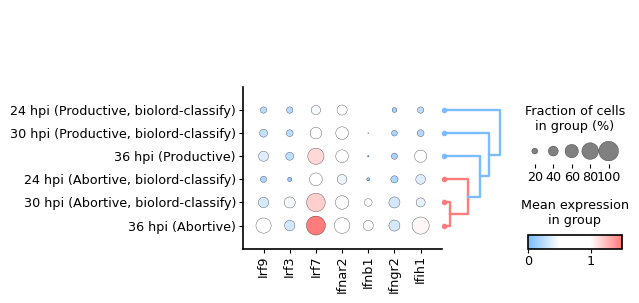

In [39]:
axs = sc.pl.dotplot(
    adata,
    ifnr_genes,
    groupby="time_abortive_classification",
    cmap=sns.blend_palette(
        [abortive_color["Productive"], "1", "1", abortive_color["Abortive"]],
        as_cmap=True,
    ),
    dendrogram=True,
    show=False,
    return_fig=True,
)

yticklabels = axs.get_axes()["mainplot_ax"].get_yticklabels()
yticklabels_new = []
node_colors = []
for ti, tick in enumerate(yticklabels):
    if "36" in tick.get_text():
        yticklabels_new.append(" ".join(tick.get_text().split(" ")[:3]) + ")")
    else:
        yticklabels_new.append(
            " ".join(tick.get_text().split(" ")[:3]) + ", biolord-classify)"
        )

    if "Abortive" in tick.get_text():
        node_colors.append(abortive_color["Abortive"])
    else:
        node_colors.append(abortive_color["Productive"])

axs.get_axes()["mainplot_ax"].set_yticklabels(yticklabels_new)

for li, line in enumerate(axs.get_axes()["group_extra_ax"].get_lines()):
    line.set_color(node_colors[-(li + 2)])

nodes = axs.get_axes()["group_extra_ax"].get_yticks()
for ni, node in enumerate(nodes):
    axs.get_axes()["group_extra_ax"].plot(0, node, ".", color=node_colors[ni])


plt.savefig(FIG_DIR_LCL + "ifnr_genes.png", format="png", dpi=300, bbox_inches="tight")
plt.show()